<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_6/6_3_Image_Transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image

#https://medium.com/@anushsom/image-augmentation-for-creating-datasets-using-pytorch-for-dummies-by-a-dummy-a7c2b08c5bcb

Image shape: (427, 640, 3)
<class 'numpy.ndarray'>


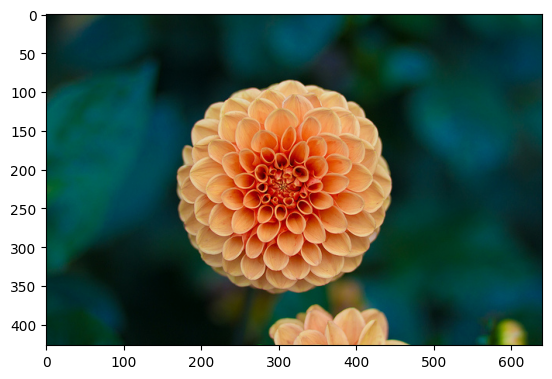

In [2]:
# завантажуємо зображення
img_np = load_sample_image("flower.jpg")  # numpy array (H, W, 3)
H, W, C = img_np.shape
print("Image shape:", img_np.shape)
print(type(img_np))

plt.imshow(img_np)
plt.show()

In [3]:
img = Image.fromarray(img_np)             # -> PIL.Image.Image
print(type(img))

<class 'PIL.Image.Image'>


In [4]:
# трансформації
flip_tf   = transforms.RandomHorizontalFlip(p=1.0)
jitter_tf = transforms.ColorJitter(brightness=0.3, contrast=0.3,
                                   saturation=0.3, hue=0.05)

#brightness ∈ [0.7, 1.3], contrast ∈ [0.7, 1.3]
#saturation ∈ [0.7, 1.3], hue shift ∈ [−0.05, +0.05] → ~±18° у колірному колі
#тобто кожне зображення випадково: стане трохи світлішим або темнішим, трохи контрастнішим,
# кольори можуть стати блідішими або насиченішими, відтінок трохи зсувається.

random_resized_crop = transforms.RandomResizedCrop(
    size=(img.size[1], img.size[0]),   # повертаємо зображення до вихідного розміру
    scale=(0.6, 1.0),      # частина оригіналу (zoom)
    ratio=(0.9, 1.1)       # невелика зміна пропорцій
)
random_rotation = transforms.RandomRotation(15)

transforms.ColorJitter(brightness, contrast, saturation, hue)
це аугментація кольору — вона випадково змінює яскравість, контраст, насиченість і відтінок кольору.
усі параметри означають діапазон випадкових змін.

| Параметр       | Опис                                         | Як розраховується діапазон                 |
| -------------- | -------------------------------------------- | ------------------------------------------ |
| **brightness** | множник для яскравості (світліше/темніше)    | випадкове число з `[max(0, 1−b), 1+b]`     |
| **contrast**   | множник для контрасту (глибина тіней/світла) | `[max(0, 1−c), 1+c]`                       |
| **saturation** | множник для насиченості (кольоровість)       | `[max(0, 1−s), 1+s]`                       |
| **hue**        | зсув відтінку кольору (в градусах кола HSV)  | `[-h, +h]`, де `h ≤ 0.5` (тобто ±180° * h) |


In [5]:
# застосовуємо
img_flip   = flip_tf(img)
img_jitter_1 = jitter_tf(img)
img_jitter_2 = jitter_tf(img)
img_jitter_3 = jitter_tf(img)
img_crop_resize = random_resized_crop(img)
img_rot = random_rotation(img)

In [6]:
def show_row(images, titles):
    plt.figure(figsize=(12,4))
    for i,(im,t) in enumerate(zip(images,titles)):
        plt.subplot(1,len(images),i+1)
        plt.imshow(im)
        plt.title(t)
        plt.axis('off')
    plt.show()

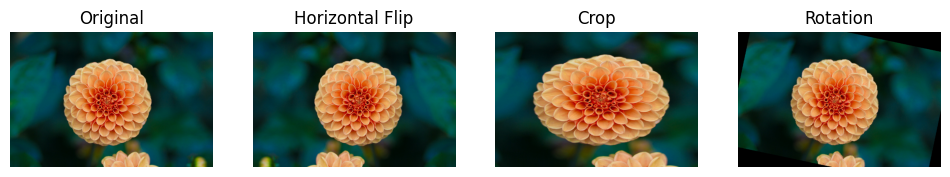

In [7]:
# результати
show_row([img, img_flip, img_crop_resize, img_rot],
         ["Original", "Horizontal Flip", "Crop", "Rotation"])



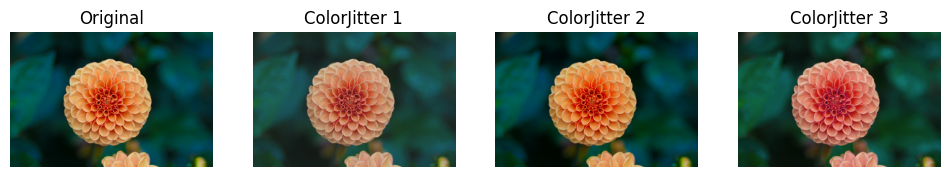

In [8]:
show_row([img, img_jitter_1, img_jitter_2, img_jitter_3],
         ["Original", "ColorJitter 1", "ColorJitter 2", "ColorJitter 3"])

In [9]:
# базовий набір трансформацій
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomApply([transforms.ColorJitter(0.3,0.3,0.3,0.05)], p=0.5),#p=0.5 - означає ймовірність застосування перетворення
    transforms.RandomResizedCrop(size=(img.size[1], img.size[0]), scale=(0.6, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])
#Compose([...]) означає — виконати всі операції послідовно на одному й тому ж зображенні.
#Тобто, вихід попереднього кроку стає входом наступного.

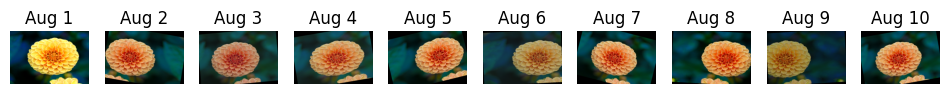

In [10]:
# приклад “комбінованої” трансформації
imgs_aug = [transforms.ToPILImage()(train_tf(img)) for _ in range(10)]
show_row(imgs_aug, [f"Aug {i+1}" for i in range(10)])

CIFAR 10

In [11]:
test_tf = transforms.Compose([transforms.ToTensor()])

In [12]:
# --- завантажуємо датасет ---
root = "./data"

train_set = datasets.CIFAR10(root=root, train=True, download=True, transform=train_tf)
test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=test_tf)

# --- створюємо DataLoader-и ---
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=256, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

100%|██████████| 170M/170M [00:02<00:00, 76.9MB/s]


Train batches: 391, Test batches: 40


Як працюють перетворення (Data Augmentation) у PyTorch:

У torchvision.datasets параметр transform не застосовується наперед,
а виконується динамічно кожного разу, коли зображення завантажується з датасету.

Тобто при кожному формуванні батчу (через DataLoader)
для кожного зображення заново виконується послідовність трансформацій із transforms.Compose([...]).

Тому одне й те саме зображення під час різних епох або навіть у різних батчах
може виглядати по-різному (наприклад, бути повернутим, затемненим, обрізаним чи перевернутим).

Це дозволяє моделі бачити нові варіації даних у кожній епосі,
зменшуючи перенавчання та підвищуючи здатність до узагальнення.#